## A feed-forward Neural Network for secondary structure prediction
This notebook looks at a Neural Network based on code from 
[Stevens and Boucher (2014, Python Programming for Biology CUP)](https://www.amazon.co.uk/Python-Programming-Biology-Bioinformatics-Beyond/dp/0521720095). We will look at how a neural network is trained and how we can assess whether after training it has useful predictive power.

In this case the neural network will be used  to predict the secondary structure of a protein from its sequence. 
It is useful to be able to predict the secondary structure of a protein for which there is only sequence available. In practice, secondary structure prediction has many uses, for instance in helping in the identification of functional domains ([Drozdetskiy et al., 2015](https://doi.org/10.1093/nar/gkv332)) and can be easily acheived using the JPRED4 server http://www.compbio.dundee.ac.uk/jpred4 (we will run this at the end of the second to compare results). 

It should be noted that the best approach to predicting a secondary structure is to use BLAST (or PSI-BLAST) to align the sequence to sequences of proteins with experimental 3D structures (those in PDB Protein Data Bank). If homologous sequences are found then the secondary structure can be expected to be same for areas with significant sequence identify. JPRED4 does such a search before switching to prediction from the sequence.

The Stevens and Boucher approach is to use the sequence in the neighbourhood of a residue as a basis for a neural network prediction.  A predictive network is trained using data on known secondary structures of k-mers of 5 amino-acids taken from a set of PDB structures. Three secondary structure states are defined: H, C, and S. H and S are helix and strand respectively while C is for coil which is a range of structures not with regular H-bonding pattern. The DSSP program is used to assess the secondary structure of PDB structures. For more details see [6aam_secondary_structure_from_PDB.ipynb](6aam_secondary_structure_from_PDB.ipynb) where DSSP data is used to get test data for this exercise.


The network here is a simple three layer feed-forward one.

<img src="https://www.researchgate.net/publication/259519062/figure/fig10/AS:667910238384136@1536253618458/A-3-layer-feed-forward-neural-network_W640.jpg" width=300>

The number of nodes in the hidden layer can be defined by the programmer. But the number of input and output nodes is defined by the sizes of the input and output data vectors.


In [8]:
# Run this cell to import numpy 
from numpy import tanh, ones, append, array, zeros, random, sum

The neural network function takes input data for the first layer of Network nodes, applies the the first weighted connections to pass the signal to the hidden layer of nodes, then applies the second weights to produce output. 

The output may not be optimized as the function also operates on the weighting during training. However after training the function gives predictions so takes its name from that. 

The weightsIn values define the strength of connection between the input nodes and the hidden nodes. Similarly weightsOut define the strengths of connection between the hidden and the output nodes. 

The weights are given as matrices with the rows indexing the nodes in a layer and the columns indexing the nodes in the other layer. 

The signalIn vector is the input features and an extra value of 1.0. This additional value is called the bias node which is used to tune the baseline response of the network. The baseline is the level without a meaningful signal. 

Setting the bias node value happens during training to adapt to the values in the input data. This means the input data don't need to pre-prepared with a mean of zero.

In [9]:
## Run this cell to define the neuralNetPredict function
def neuralNetPredict(inputVec, weightsIn, weightsOut):
    """ uses the current weights in a neural network
    to make a prediction from an input vector
    all input and output are numpy data structures""" 
    signalIn = append(inputVec, 1.0) # input layer

    prod = signalIn * weightsIn.T
    sums = sum(prod, axis=1)
    signalHid = tanh(sums)    # hidden    layer

    prod = signalHid * weightsOut.T
    sums = sum(prod, axis=1)
    signalOut = tanh(sums)    # output    layer

    return signalIn, signalHid, signalOut
 

Note that the numpy `.T` methodn gives the transpose of a matrix - that is the matrix with the columns turned into rows and the rows turned into columns. 

This is used so that the input signal gets applied to all the hidden nodes.

The network applies the hyperbolic tangent function (tanh) to get the signal output from all the nodes in layer. Hyperbolic tan is a sigmoidal function that varies from -1 to 1, so it is much better than ordinary tan that runs off to infinity. 

<img src="https://mathworld.wolfram.com/images/interactive/TanhReal.gif" width=300></img> 

The tanh function defines the output of that node given an input or set of inputs. As a nod to the output of neurones, which depends on an activation level across their cell membrane, the output function is called the *Activation* function.

In operation only the signalOut from the output layer is of interest. But during training the response signals from the other layers are also needed to adjust the weighting scheme.

### Training 

The weighting scheme (and gain) will be optimized by using a training dataset. 

The training data will be an input feature vector and a known output vector. The order of the data will be randomly shuffled to avoid bias. The number of hidden nodes needs to be specified and the number of optimization cycles. 

After each cycle the 'error' between the output signal of the network and the known training set output is used to adjust the network weights. The difference is combined with the *gradient* in the signal values - calculated from the tanh activation function (conveniently the gradient of tanh(sig) is 1-sig<sup>2</sup> or 1 - {sig x sig}). 

Early in training large difference can make the network go haywire so the speed of weight changing is damped down by a 'rate' and 'momentum' multipliers (usually the default values of 0.5 and 0.2 are good enough). 

More damping would mean that many more cycles would be needed for the weights to converge. 

The training will work back from the value of the error to adjust the weighting scheme of the network. This is called *back propagation*. 

The use of the gradient is crucial as it means initial adjustments will be large but then finer adjustments will be made as the optimum is approached.

In [80]:
## Run this cell to define the neuralNetTrain function
def neuralNetTrain(trainData, numHid, steps=100, rate=0.5, momentum=0.2, silent=False):
    """ uses training data to set the weights in a simple
    neural network, number of hidden nodes is specified"""
    numInp = len(trainData[0][0])
    numOut = len(trainData[0][1])
    numInp += 1
    minError = None

    sigInp = ones(numInp)
    sigHid = ones(numHid)
    sigOut = ones(numOut)
    
    wInp = random.random((numInp, numHid))-0.5
    wOut = random.random((numHid, numOut))-0.5
    
    bestWeightMatrices = (wInp, wOut)

    cInp = zeros((numInp, numHid))
    cOut = zeros((numHid, numOut))

    for x, (inputs, knownOut) in enumerate(trainData):
        trainData[x] = (array(inputs), array(knownOut))
 
    for step in range(steps):  
        random.shuffle(trainData) # Important to avoid bias
        error = 0.0
 
        for inputs, knownOut in trainData:
            sigIn, sigHid, sigOut = neuralNetPredict(inputs, wInp, wOut)

            diff = knownOut - sigOut
            error += sum(diff * diff)

            gradient = ones(numOut) - (sigOut*sigOut)
            outAdjust = gradient * diff 

            diff = sum(outAdjust * wOut, axis=1)
            gradient = ones(numHid) - (sigHid*sigHid)
            hidAdjust = gradient * diff 

            # update output 
            change = outAdjust * sigHid.reshape(numHid, 1)
            wOut += (rate * change) + (momentum * cOut)
            cOut = change
 
            # update input 
            change = hidAdjust * sigIn.reshape(numInp, 1)
            wInp += (rate * change) + (momentum * cInp)
            cInp = change
 
        if (minError is None) or (error < minError):
            minError = error
            bestWeightMatrices = (wInp.copy(), wOut.copy())
            if not silent:
                print("Step: %d Error: %f" % (step, error))
    
    return bestWeightMatrices

### Testing the functions
Simple data to test a network can be binary input vectors with the desired output being an 'exclusive OR' (EOR) response https://en.wikipedia.org/wiki/Exclusive_or. This responds `True` if any input is `True` but False is both inputs are `True` or `False. 

In [11]:
##Run this cell to define the test data
testEORdata = [[[0,0], [0]],
               [[0,1], [1]], 
               [[1,0], [1]], 
               [[1,1], [0]]]

The network test uses two hidden nodes - in real use several values would be tried to find the best performance.
Run the cell below to see if the training converges.

In [12]:
## Run this cell to train the network
wMatrixIn, wMatrixOut = neuralNetTrain(testEORdata, 2, 1000)

Step: 0 Error: 2.155768
Step: 1 Error: 1.391256
Step: 2 Error: 1.174905
Step: 5 Error: 1.077870
Step: 8 Error: 1.036137
Step: 13 Error: 0.974505
Step: 15 Error: 0.968126
Step: 17 Error: 0.963763
Step: 18 Error: 0.943993
Step: 21 Error: 0.918696
Step: 23 Error: 0.910035
Step: 25 Error: 0.904738
Step: 27 Error: 0.904109
Step: 28 Error: 0.886103
Step: 30 Error: 0.880164
Step: 34 Error: 0.875396
Step: 39 Error: 0.870171
Step: 40 Error: 0.869399
Step: 49 Error: 0.866733
Step: 50 Error: 0.853426
Step: 52 Error: 0.849690
Step: 56 Error: 0.845411
Step: 58 Error: 0.832798
Step: 73 Error: 0.821713
Step: 102 Error: 0.818708
Step: 117 Error: 0.810672
Step: 121 Error: 0.808864
Step: 134 Error: 0.802754
Step: 193 Error: 0.790337
Step: 198 Error: 0.777828
Step: 252 Error: 0.770825
Step: 304 Error: 0.758034
Step: 319 Error: 0.739479
Step: 321 Error: 0.721897
Step: 323 Error: 0.614169
Step: 324 Error: 0.603006
Step: 326 Error: 0.470133
Step: 328 Error: 0.422640
Step: 329 Error: 0.287381
Step: 330 Error

You should find good convergence has occurred and there is no oscillation. Perhaps you can see that the initial steps are giving large changes in the error while later on there are smaller and smaller changes. This is owing to the effect of the gradient calculation. The changes in the actual weights are not printed, but will follow the same trend.

The output weight matrices will now be stored in the kernel as `wMatrixIn` and `wMatrixOut` as can then be run on test data for evaluation. 

Run the following cell to compare the output of the network with the actual values of the training set outputs.

In [15]:
# Run this cell to test the neural network produces the expected output for the training set
for inputs, knownOut in testEORdata:
    sIn, sHid, sOut =    neuralNetPredict(array(inputs), wMatrixIn, wMatrixOut)
    print('input', inputs, ' should have output ', knownOut, 'actual output {:.2f}'.format(sOut[0]))

input [1 1]  should have output  [0] actual output 0.01
input [1 0]  should have output  [1] actual output 0.98
input [0 1]  should have output  [1] actual output 0.98
input [0 0]  should have output  [0] actual output -0.00


You can see that the neural net produces actual output that matches the training set data.

This is only a limited test because to properly test data should be used inputs with known output but which were not included in the training set. In this case it is not possible to give any new data for the EOR function as the training set covered all possible responses!

## Apply the neural net to secondary structure prediction

Here is a very limited set of training data that will be used to start with. It shows the raw format which is a 5-mer string and the secondary structure that was observed for the central residue of this in at least one PDB structure. 


In [16]:
##Run this cell to define the training set
small_training_set = [('ADTLL','S'),
                      ('DTLLI','S'),
                      ('TLLIL','S'),
                      ('LLILG','S'),
                      ('LILGD','S'),
                      ('ILGDS','S'),
                      ('LGDSL','C'),
                      ('GDSLS','H'),
                      ('DSLSA','H'),
                      ('SLSAG','H'),
                      ('LSAGY','H'),
                      ('SAGYR','C'),
                      ('AGYRM','C'),
                      ('GYRMS','C'),
                      ('YRMSA','C'),
                      ('RMSAS','C')]

### Simple feature vectors for sequence data

The neural net needs its data to provided in a numeric form as a vector like that used in the EOR example.
A simple numbering scheme is used to convert to the sequence alphabet to a numeric form as an input vector. For proteins that is number from 0 to 19 from the list of one-letter codes.

k-mers with k=5 are used. It should be noted that the secondary structure is that associated with the middle residue of the 5 mer. The possible outputs are also coded as integers for the more restricted alphabet of H, C, and S

In [17]:
##Run this cell to define the dictionaries for the vectors
aminoAcids = 'ACDEFGHIKLMNPQRSTVWY'
aaIndexDict = {}
for i, aa in enumerate(aminoAcids):
        aaIndexDict[aa] = i

ssIndexDict = {}
ssCodes = 'HCS'
for i, code in enumerate(ssCodes):
        ssIndexDict[code] = i


The actual structure is a simplified output from the DSSP program mentioned in the introduction. DSSP acutally distinguishes more structures that the three here - for example there are other kinds of helix. But these complications are not dealt with.

The training data has to be converted to the numerical code. Here is a function to to that.

In [19]:
##Run this cell to define the function
def convertSeqToVector(seq, indexDict):
    """converts a one-letter sequence to numerical
    coding for neural network calculations"""   
    numLetters = len(indexDict)
    vector = [0.0] * len(seq) * numLetters
    for pos, letter in enumerate(seq):
        index = pos * numLetters + indexDict[letter]    
        vector[index] = 1.0
    return vector

The training data is prepared with the `convertSeqToVector`.

In [20]:
##Run this cell to create the training data
small_training_vector = []
for seq, ss in small_training_set:
        inputVec = convertSeqToVector(seq, aaIndexDict)
        outputVec = convertSeqToVector(ss, ssIndexDict)
        small_training_vector.append( (inputVec, outputVec) )

And then the network is trained. Here there are 3 hidden nodes specified.

In [22]:
small_training_matrix_in, small_training_matrix_out = neuralNetTrain(small_training_vector, 3, 1000)

Step: 0 Error: 18.923801
Step: 1 Error: 11.275540
Step: 3 Error: 8.667626
Step: 4 Error: 5.158456
Step: 5 Error: 3.388506
Step: 6 Error: 3.183800
Step: 7 Error: 2.260478
Step: 8 Error: 1.728604
Step: 9 Error: 0.837363
Step: 10 Error: 0.441825
Step: 11 Error: 0.418651
Step: 13 Error: 0.372228
Step: 14 Error: 0.279643
Step: 21 Error: 0.173488
Step: 24 Error: 0.106576
Step: 37 Error: 0.060687
Step: 41 Error: 0.060271
Step: 76 Error: 0.051542
Step: 77 Error: 0.050923
Step: 84 Error: 0.049465
Step: 86 Error: 0.033449
Step: 87 Error: 0.021676
Step: 91 Error: 0.017242
Step: 132 Error: 0.011145
Step: 152 Error: 0.010751
Step: 153 Error: 0.008127
Step: 156 Error: 0.007079
Step: 178 Error: 0.005158
Step: 308 Error: 0.004664
Step: 309 Error: 0.004587
Step: 312 Error: 0.004350
Step: 317 Error: 0.004331
Step: 320 Error: 0.004158
Step: 321 Error: 0.002978
Step: 372 Error: 0.002732
Step: 378 Error: 0.002606
Step: 382 Error: 0.002406
Step: 383 Error: 0.002281
Step: 389 Error: 0.001885
Step: 428 Error:

You will see for this small training set the neural net converges quickly. Lets test how the neural net performs.

The following function can be used to make a predict for any given 5-mer sequence

In [23]:
# run this cell to define predict_seq function.
def predict_seq(seq, w_matrix_in, w_matrix_out):
    """
    returns a prediction either 'H', 'S' or 'C' for the input 5-mer sequence seq using
    the neuralNetPredict funciton with matrix weights w_matrix_in, w_matrix_out
    """
    vector_seq = convertSeqToVector(seq, indexDict=aaIndexDict)
    array_seq = array([vector_seq,])
    sIn, sHid, sOut =    neuralNetPredict(array_seq, w_matrix_in, w_matrix_out)
    index = sOut.argmax()
    return ssCodes[index]

How well does the neural network do for the `small_training_set` data that was used to train it?

The first sequence in this was `'ADTLL` that was a strand `S`. Let us 'predict' what seconary the neural network expects for this sequence:

In [25]:
test_seq = 'ADTLL'
predict = predict_seq(test_seq, small_training_matrix_in, small_training_matrix_out)
print('neural net predicts', test_seq, 'will be', predict)

neural net predicts ADTLL will be S


You should see that `ADTLL` is predicted to be `S` just like in the input set. But what of the other cases in `small_training_set`? Write python to find out the percentage success rate for the neural network for `small_training_set`:

In [ ]:
# your turn write Python to find out percentage the success rate for small_training_set

In [27]:
# ANSWER REMOVE BEFORE PUBLICATION
success = 0
total = 0
for test_seq, known_ss in small_training_set:
    predict = predict_seq(test_seq, small_training_matrix_in, small_training_matrix_out)
    if predict == known_ss:
        success += 1
    total += 1
print('percentage success for small_training_set {:.1f} %'.format(100.*success/total))

percentage success for small_training_set 100.0 %


You should have found the success rate for `predicting` the data used for training is 100% or close to it. But the real test of a neural net is that it should be able to make predictions for input data it has not seen before.

To test the predictive power of the neural net trained on the `small_training_set` use the `test_data_from_6aam` (see  [6aam_secondary_structure_from_PDB.ipynb](6aam_secondary_structure_from_PDB.ipynb) for its derivation): 

In [28]:
# test data from PDB entry 6AAM
test_data_from_6aam = [('FHKRY', 'C'), ('DLGEG', 'C'), ('SLYCY', 'S'), ('GTGEM', 'C'),
                       ('LKADA', 'C'), ('SGWKQ', 'H'), ('RTLYH', 'C'), ('YKGCC', 'S'),
                       ('ASLQL', 'S'), ('PLGSL', 'C'), ('RHSIG', 'C'), ('LFAQQ', 'H'),
                       ('AYLHA', 'H'), ('RNLAA', 'C'), ('DNDRL', 'C'), ('FGLAK', 'C'),
                       ('HEYYR', 'C'), ('DSPVF', 'C'), ('CLKEY', 'H'), ('SDVWS', 'H'),
                       ('YELLT', 'H'), ('QSPPT', 'H'), ('IGLAQ', 'S'), ('LRLTE', 'H'),
                       ('ERLPR', 'C'), ('AEVYH', 'H'), ('WETEA', 'S'), ('FENLI', 'H'), 
                       ('VHEKY', 'H')]

In [29]:
# your turn write Python to find out percentage the success rate of the
# neural_net trained on small_training_set when test on test_data_from_6aam

In [30]:
# ANSWER REMOVE BEFORE PUBLICATION
success = 0
total = 0
for test_seq, known_ss in test_data_from_6aam:
    predict = predict_seq(test_seq, small_training_matrix_in, small_training_matrix_out)
    if predict == known_ss:
        success += 1
    total += 1
print('percentage success for test_data_from_6aam  {:.1f} %'.format(100.*success/total))

percentage success for test_data_from_6aam  27.6 %


You should find the success rate is low - in fact below 30%. Considering there are only 3 states possible a reasonable comparison is to 'predict' that every residue is coil 'C'. This produces a success rate of 45%:

In [36]:
n_coil = sum([ss == 'C' for _, ss in  test_data_from_6aam])
percent_all_coil = 100.*n_coil/len(test_data_from_6aam)
print('percentage success predicting all coil {:.1f}%'.format(percent_all_coil))

percentage success predicting all coil 44.8%


So the success rate for neural net trained on a set of 16 examples is below the all-coil benchmark. It has no real predictive power. This is not really surprising as for example the amino acid proline (one letter code `P`) does not appear anywhere in the `small_training_set` but appears a number of times in `test_data_from_6aam`

But do not worry as Stevens and Boucher provide secondary structure data for 26242 5-mers and confidentally assert 'Using this as as an input would give a vastly superior result'. So let's load this dataset and checkout whether more training data helps in practice.

### Reading a larger training set

The  much dataset from Stevens and Boucher is provided as a comma separated file called:
[PDB_protein_secondary_5mers.csv](PDB_protein_secondary_5mers.csv) that is supplied alongside this Notebook.

You should now read the data from [PDB_protein_secondary_5mers.csv](PDB_protein_secondary_5mers.csv) into a list `large_data_set`.

The Python `csv` module `reader` method should be used for this. See https://pymotw.com/3/csv/ or Google for another tutorial.

In [41]:
# your turn read PDB_protein_secondary_5mers.csv into the list large_data_set

In [48]:
# ANSWER REMOVE BEFORE PUBLICATION
from csv import reader
with open('PDB_protein_secondary_5mers.csv') as csv_file:
    csv_reader = reader(csv_file, delimiter=',')
    large_data_set = list(csv_reader)
print('have read', len(large_data_set), 'lines from csv file')
print('first record', large_data_set[0], 'last record', large_data_set[-1])

have read 26242 lines from csv file
first record ['MGKMY', 'S'] last record ['LAMKL', 'H']


In [49]:
# run this cell to check that list large_data_set has the data from PDB_protein_secondary_5mers.csv
assert type(large_data_set) is list
assert len(large_data_set) == 26242
assert large_data_set[-1] == ['LAMKL', 'H']

Now you have read in the `large_data_set` you go ahead and train the neural network on all this data. In practice you would find this does not work well, running slowly with big convergence issues. Instead lets try using a subset of the data to train the neural network. Lets start with the first 100 records:

In [53]:
# make a selection of data from the `large_data_set` as larger_training_set
larger_training_set = large_data_set[:100]

In [54]:
# Run this cell to create the larger_training_vector from larger_training_set
larger_training_vector = []
for seq, ss in larger_training_set:
        inputVec = convertSeqToVector(seq, aaIndexDict)
        outputVec = convertSeqToVector(ss, ssIndexDict)
        larger_training_vector.append( (inputVec, outputVec) )

In [76]:
# now train the neural network on the larger training vector.
larger_training_matrix_in, larger_training_matrix_out = neuralNetTrain(larger_training_vector, 3, 1000)

Step: 0 Error: 104.244087
Step: 3 Error: 89.086720
Step: 5 Error: 82.723386
Step: 6 Error: 77.121099
Step: 7 Error: 68.926343
Step: 8 Error: 66.370467
Step: 9 Error: 65.753416
Step: 10 Error: 45.793486
Step: 11 Error: 40.858301
Step: 13 Error: 35.876907
Step: 15 Error: 29.079697
Step: 18 Error: 27.140895
Step: 19 Error: 23.189806
Step: 20 Error: 22.541265
Step: 21 Error: 22.387350
Step: 23 Error: 19.873106
Step: 29 Error: 15.813635
Step: 37 Error: 13.787603
Step: 44 Error: 13.707655
Step: 90 Error: 11.271791
Step: 114 Error: 10.930608
Step: 118 Error: 10.887742
Step: 128 Error: 10.501612
Step: 236 Error: 10.174853
Step: 256 Error: 9.752790
Step: 323 Error: 9.740842
Step: 407 Error: 6.406704
Step: 434 Error: 5.355145
Step: 520 Error: 4.602612
Step: 583 Error: 3.628552


In [77]:
# run this cell to define a function to find percentage_sucess
def percentage_success(test_set, matrix_in, matrix_out):
    """
    returns the percentage_success for the test_set using 
    neural network defined by matrix_in and matrix_out
    """
    predictions = [predict_seq(ts, matrix_in, matrix_out) for ts, _ in test_set]
    known = [k for _, k in test_set]
    percentage = 100.*sum([p == k for p, k in zip(predictions, known)])/len(test_set)
    return percentage

In [78]:
# run this cell to assess percentage success rate on training and test data
train_percent = percentage_success(larger_training_set, larger_training_matrix_in, larger_training_matrix_out)
independent_percent = percentage_success(test_data_from_6aam, larger_training_matrix_in, larger_training_matrix_out)
print('Successful prediction rates:')
print('   training_set data:       {:.1f}%'.format(train_percent))
print('   test data from PDB 6AAM: {:.1f}%'.format(independent_percent))

Successful prediction rates:
   training_set data:       98.0%
   test data from PDB 6AAM: 41.4%


The results you will get above will vary. Sometimes the neural network converges with small error whereas sometimes it fails to converge. Lets try running the process 5 times.

In [81]:
# run this cell run the training process a number of times - may be slow.
for _ in range(5): # number of repeats
    larger_training_matrix_in, larger_training_matrix_out = neuralNetTrain(larger_training_vector, 3, 1000, 
                                                                           silent=True)
    train_percent = percentage_success(larger_training_set, larger_training_matrix_in, larger_training_matrix_out)
    independent_percent = percentage_success(test_data_from_6aam, larger_training_matrix_in, larger_training_matrix_out)
    print('Successful prediction rates:')
    print('   training_set data:       {:.1f}%'.format(train_percent))
    print('   test data from PDB 6AAM: {:.1f}%'.format(independent_percent))

Successful prediction rates:
   training_set data:       100.0%
   test data from PDB 6AAM: 51.7%
Successful prediction rates:
   training_set data:       98.0%
   test data from PDB 6AAM: 41.4%
Successful prediction rates:
   training_set data:       98.0%
   test data from PDB 6AAM: 37.9%
Successful prediction rates:
   training_set data:       100.0%
   test data from PDB 6AAM: 44.8%
Successful prediction rates:
   training_set data:       84.0%
   test data from PDB 6AAM: 41.4%


This was the result I got:
```
Successful prediction rates:
   training_set data:       100.0%
   test data from PDB 6AAM: 51.7%
Successful prediction rates:
   training_set data:       98.0%
   test data from PDB 6AAM: 41.4%
Successful prediction rates:
   training_set data:       98.0%
   test data from PDB 6AAM: 37.9%
Successful prediction rates:
   training_set data:       100.0%
   test data from PDB 6AAM: 44.8%
Successful prediction rates:
   training_set data:       84.0%
   test data from PDB 6AAM: 41.4%
```
You will set that the results vary. Sometime the neural net converges and can 'predict' the input data sometimes not. Results for 6AAM data are between 38% to 51% success. Compare this to around 28% for the small training set with 16 examples and 42% for an 'all coil' prediction. So the conclusion is that this will a data set size 200 

Now it is your turn. 
* Try training with datasets of size 200, 400 and 800 
* what is the best success rate for 6AAM you can obtain? 
* You can try altering the values of `rate` `momentum` to help the convergence. I found that lowering the `rate` to 0.1 helped.

Keep your results in the table below:

### Table of results (to be completed)


| train data set size | %prediction on training data | %prediction 6aam data        |
| ------------------- | -----------------------------| -----------------------------|
|      100            |  100, 98, 98,  100, 84       | 51.7, 41.4, 37.9, 44.8, 41.4 |
|      200            | | |
|      400            | | |
|      800            | | |

In [91]:
# ANSWER
for train_data_size in 16, 100, 200, 400, 800, 1600:
    larger_training_set = large_data_set[:train_data_size]
    larger_training_vector = []
    for seq, ss in larger_training_set:
        inputVec = convertSeqToVector(seq, aaIndexDict)
        outputVec = convertSeqToVector(ss, ssIndexDict)
        larger_training_vector.append( (inputVec, outputVec) )
    train_percents = []
    independent_percents = []
    for _ in range(5): # number of repeats
        larger_training_matrix_in, larger_training_matrix_out = neuralNetTrain(larger_training_vector, 3, 1000, 
                                                                           silent=True,
                                                                           rate=0.1)
        train_percent = percentage_success(larger_training_set, larger_training_matrix_in, larger_training_matrix_out)
        independent_percent = percentage_success(test_data_from_6aam, larger_training_matrix_in, larger_training_matrix_out)
        print(f'training_data_size: {train_data_size}  train: {train_percent:.1f} 6AAM: {independent_percent:.1f}')
        train_percents.append(f'{train_percent:.1f}')
        independent_percents.append(f'{independent_percent:.1f}')
    print(train_data_size, ','.join(train_percents), ','.join(independent_percents))

training_data_size: 16  train: 100.0 6AAM: 31.0
training_data_size: 16  train: 100.0 6AAM: 37.9
training_data_size: 16  train: 100.0 6AAM: 37.9
training_data_size: 16  train: 100.0 6AAM: 37.9
training_data_size: 16  train: 100.0 6AAM: 31.0
16 100.0,100.0,100.0,100.0,100.0 31.0,37.9,37.9,37.9,31.0
training_data_size: 100  train: 99.0 6AAM: 37.9
training_data_size: 100  train: 100.0 6AAM: 41.4
training_data_size: 100  train: 99.0 6AAM: 34.5
training_data_size: 100  train: 99.0 6AAM: 48.3
training_data_size: 100  train: 99.0 6AAM: 41.4
100 99.0,100.0,99.0,99.0,99.0 37.9,41.4,34.5,48.3,41.4
training_data_size: 200  train: 95.0 6AAM: 48.3
training_data_size: 200  train: 95.5 6AAM: 48.3
training_data_size: 200  train: 94.0 6AAM: 41.4
training_data_size: 200  train: 94.0 6AAM: 37.9
training_data_size: 200  train: 94.5 6AAM: 55.2
200 95.0,95.5,94.0,94.0,94.5 48.3,48.3,41.4,37.9,55.2
training_data_size: 400  train: 88.8 6AAM: 41.4
training_data_size: 400  train: 87.8 6AAM: 58.6
training_data_si

In [92]:
# ANSWER - larger sets
for train_data_size in 3200, 6400, 12800, 26242:
    larger_training_set = large_data_set[:train_data_size]
    larger_training_vector = []
    for seq, ss in larger_training_set:
        inputVec = convertSeqToVector(seq, aaIndexDict)
        outputVec = convertSeqToVector(ss, ssIndexDict)
        larger_training_vector.append( (inputVec, outputVec) )
    train_percents = []
    independent_percents = []
    for _ in range(5): # number of repeats
        larger_training_matrix_in, larger_training_matrix_out = neuralNetTrain(larger_training_vector, 3, 1000, 
                                                                           silent=True,
                                                                           rate=0.1)
        train_percent = percentage_success(larger_training_set, larger_training_matrix_in, larger_training_matrix_out)
        independent_percent = percentage_success(test_data_from_6aam, larger_training_matrix_in, larger_training_matrix_out)
        print(f'training_data_size: {train_data_size}  train: {train_percent:.1f} 6AAM: {independent_percent:.1f}')
        train_percents.append(f'{train_percent:.1f}')
        independent_percents.append(f'{independent_percent:.1f}')
    print(train_data_size, ','.join(train_percents), ','.join(independent_percents))

training_data_size: 3200  train: 38.1 6AAM: 44.8
training_data_size: 3200  train: 62.7 6AAM: 51.7
training_data_size: 3200  train: 61.7 6AAM: 55.2
training_data_size: 3200  train: 59.5 6AAM: 58.6
training_data_size: 3200  train: 56.6 6AAM: 58.6
3200 38.1,62.7,61.7,59.5,56.6 44.8,51.7,55.2,58.6,58.6
training_data_size: 6400  train: 57.2 6AAM: 55.2
training_data_size: 6400  train: 45.2 6AAM: 44.8
training_data_size: 6400  train: 45.7 6AAM: 37.9
training_data_size: 6400  train: 42.8 6AAM: 44.8
training_data_size: 6400  train: 49.5 6AAM: 44.8
6400 57.2,45.2,45.7,42.8,49.5 55.2,44.8,37.9,44.8,44.8
training_data_size: 12800  train: 53.5 6AAM: 58.6
training_data_size: 12800  train: 52.8 6AAM: 44.8
training_data_size: 12800  train: 56.5 6AAM: 51.7
training_data_size: 12800  train: 47.4 6AAM: 44.8
training_data_size: 12800  train: 51.7 6AAM: 58.6
12800 53.5,52.8,56.5,47.4,51.7 58.6,44.8,51.7,44.8,58.6
training_data_size: 26242  train: 45.5 6AAM: 37.9
training_data_size: 26242  train: 55.8 6AAM:

### My table of results

Run with `rate=0.1`


| train data set size | %prediction on training data | %prediction 6aam data        |
| ------------------- | -----------------------------| -----------------------------|
| 16 |  100.0,100.0,100.0,100.0,100.0 | 31.0,37.9,37.9,37.9,31.0 |
| 100  | 99.0,100.0,99.0,99.0,99.0 | 37.9,41.4,34.5,48.3,41.4 |
| 200  | 94.0,94.0,95.0,95.5,94.5 | 48.3,48.3,41.4,37.9,55.2 |
| 400  | 66.0,88.8,87.8,85.0,88.2 | 41.4,58.6,48.3,62.1,55.2 |
| 800  | 80.1,67.9,62.2,78.2,77.6 | 41.4,48.3,58.6,37.9,37.9 |
| 1600 | 68.7,70.9,39.5,73.0,72.6 | 51.7,48.3,34.5,48.3,51 |
| 3200 | 38.1,62.7,61.7,59.5,56.6 | 44.8,51.7,55.2,58.6,58.6 |
| 6400 | 57.2,45.2,45.7,42.8,49.5 | 55.2,44.8,37.9,44.8,44.8 |
| 12800|  53.5,52.8,56.5,47.4,51.7 | 58.6,44.8,51.7,44.8,58.6
| 26242| 45.5,55.8,53.8,52.3,36.0  | 37.9,48.3,58.6,48.3,41.4 |

This is a lot of data lets plot it


In [100]:
# ANSWER success data in Python for a scatter plot
predict_size_training_6aam =  [(16, (100.0,100.0,100.0,100.0,100.0), (31.0,37.9,37.9,37.9,31.0)),
                               (100,  (99.0,100.0,99.0,99.0,99.0),  (37.9,41.4,34.5,48.3,41.4)),
                               (200,  (94.0,94.0,95.0,95.5,94.5), (48.3,48.3,41.4,37.9,55.2)),
                               (400,  (66.0,88.8,87.8,85.0,88.2), (41.4,58.6,48.3,62.1,55.2)),
                               (800,  (80.1,67.9,62.2,78.2,77.6), (41.4,48.3,58.6,37.9,37.9)), 
                               (1600, (68.7,70.9,39.5,73.0,72.6), (51.7,48.3,34.5,48.3,51)), 
                               (3200,  (38.1,62.7,61.7,59.5,56.6), (44.8,51.7,55.2,58.6,58.6)), 
                               (6400,  (57.2,45.2,45.7,42.8,49.5), (55.2,44.8,37.9,44.8,44.8)), 
                               (12800, (53.5,52.8,56.5,47.4,51.7),  (58.6,44.8,51.7,44.8,58.6)),
                               (26242, (45.5,55.8,53.8,52.3,36.0),  (37.9,48.3,58.6,48.3,41.4))]
training_x = []
training_y = []
test_x = []
test_y = []
for set_size, training, test in predict_size_training_6aam:
    for percent in training:
        training_x.append(set_size)
        training_y.append(percent)
    for percent in test:
        test_x.append(set_size)
        test_y.append(percent)
        
                                
                

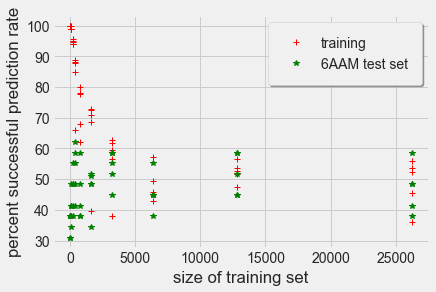

In [129]:
# ANSWER
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.plot(training_x, training_y, '+', color='red', label='training')
plt.plot(test_x, test_y, '*', color='green', label='6AAM test set')
plt.xlabel('size of training set')
plt.ylabel('percent successful prediction rate')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, frameon=True)

The conclusion - even with a lot of data this procedure is only marginally predictive. The neural net ability to reproduce the input data gets progressively worse the more data that is feed in. It appears that using 12000 data points produces the 'best' results for a indepenent test set. This amount of data produces predictions that are around 45-55% accurate compared to 43% for an 'all coil' prediction

## What is going on?

As we have seen in the previous section results for the neural network trained on 5-mer data are not that impressive. Let us step back and examine whether this a sensible approach for prediction. The neural network aims to predict the secondary structure for the central residue in a 5-mer from the sequence of the 5-mer alone. Does a particular 5-mer sequence always have the same secondary structure for the central residue? 

The same 5-mer occurs in the `large_data_set` a number of times. Let us examine the dataset using a dictionary to reprocess it:

In [116]:
values = {}
for k, v in large_data_set:
    if k not in values:
        values[k] = [v]
    else:
        values[k] = values[k] + [v]
print('number of unique 5-mers in large_data_set', len(values))
print('so there are', len(large_data_set)-len(values), ' 5-mers that appear 2 or more times')
print('This is {:.1f}% of total 5-mers'.format( 100.*(len(large_data_set)-len(values))/len(values) ))



number of unique 5-mers in large_data_set 23458
so there are 2784  5-mers that appear 2 or more times
This is 11.9% of total 5-mers
DEGLE ['H', 'H', 'H', 'C', 'H']
GVTVL ['S', 'H', 'S', 'S', 'S']
INAAS ['C', 'H', 'C', 'H', 'C', 'H', 'C', 'H']
GYAQS ['H', 'H', 'S', 'H', 'H']
KFEKD ['H', 'H', 'H', 'H', 'C']
AKGKS ['C', 'C', 'C', 'H', 'C']
AKAGL ['H', 'H', 'C', 'H', 'H']
LKAKG ['C', 'C', 'H', 'C', 'C']
EEELA ['H', 'H', 'H', 'H', 'H']
LAKEF ['H', 'H', 'H', 'H', 'H']
ELKAK ['H', 'H', 'H', 'H', 'H']
AVEAL ['H', 'S', 'S', 'S', 'S']
GGYAQ ['H', 'S', 'H', 'H', 'H']
SGLLA ['C', 'C', 'C', 'C', 'C', 'C']


So around 12% of the data is repeats. Let us look at 5-mers which occur 5 or more times in the dataset and their secondary structure:

In [117]:
for k, v in values.items():
    if len(v) > 4:
        print(k, v)

DEGLE ['H', 'H', 'H', 'C', 'H']
GVTVL ['S', 'H', 'S', 'S', 'S']
INAAS ['C', 'H', 'C', 'H', 'C', 'H', 'C', 'H']
GYAQS ['H', 'H', 'S', 'H', 'H']
KFEKD ['H', 'H', 'H', 'H', 'C']
AKGKS ['C', 'C', 'C', 'H', 'C']
AKAGL ['H', 'H', 'C', 'H', 'H']
LKAKG ['C', 'C', 'H', 'C', 'C']
EEELA ['H', 'H', 'H', 'H', 'H']
LAKEF ['H', 'H', 'H', 'H', 'H']
ELKAK ['H', 'H', 'H', 'H', 'H']
AVEAL ['H', 'S', 'S', 'S', 'S']
GGYAQ ['H', 'S', 'H', 'H', 'H']
SGLLA ['C', 'C', 'C', 'C', 'C', 'C']


This shows that the same 5-mer can have different secondary structures depending on its context.

So there will always be a limitation of the neural net in that by taking the 5-mer out of context means a single (most common?) value can be predicted. It might be benefical to reprocess the training data to give only the most common instance or perhaps to include the ambiguity by in the `OutputVec`.  

But stepping back suggests an alternative approach might be more sensible. It is well-known that helix and sheet formation is cooperative and so there are stretches of 2ndary structure. For instance for out test case 6aam both strands and helices tend to occur together often in stretches of 5 residues or more:

<img src="https://www.rcsb.org/pdb/explore/remediatedChain.do?structureId=6AAM&params.annotationsStr=Site%20Record,DSSP&chainId=A">

One of the oldest approaches to predicting 2ndary structure the GOR method https://en.wikipedia.org/wiki/GOR_method uses the conditional probability of the amino acid to form a secondary structure given that its immediate neighbors have already formed that structure. It is likely that a neural network that is trained on data including neighbour secondary structure might do better than the approach here. One possibility would be to use 3-mer sequence data but to add the secondary structure HSC for the first and last amino acids to predict the sequence for the central amino acid.



# How well does a well-trained state-of-the-art neural network do?

As discussed in the introduction JPRED4 is considered one of the best approaches for predicting the secondary structure from sequence. After checking whether there is a homologous sequence in the PDB it goes onto to The protein sequence is then searched against UniRef90 and an alignment constructed with PSI-BLAST. An HMM profile is obtained from the alignment. The HMM profile and alignment are then supplied to the neural network that has "100 hidden units". Full details of the algorithm used can be found at https://doi.org/10.1093/nar/gkn238. So rather than using the sequence alone JPRED4 uses information about related sequences (the reader should consider why this is useful - would you expect mutation of a residue in a mobile external coil section of structure to have the same effect as that in a helix at the centre of a structure).

Try running JPRED4 secondary structure prediction http://www.compbio.dundee.ac.uk/jpred4
for our 6AAM test case using the FASTA sequence from https://www.ebi.ac.uk/pdbe/entry/pdb/6aam/protein/1

```
>pdb|6aam|A
GPGDPTVFHKRYLKKIRDLGEGHFGKVSLYCYDPTNDGTGEMVAVKALKADAGPQHRSGWKQEIDILRTLYHEHIIKYKGCCEDAGAASLQLVMEYVPLGSLRDYLPRHSIGLAQLLLFAQQICEGMAYLHAQHYIHRNLAARNVLLDNDRLVKIGDFGLAKAVPEGHEYYRVREDGDSPVFWYAPECLKEYKFYYASDVWSFGVTLYELLTHCDSSQSPPTKFLELIGLAQGQMTVLRLTELLERGERLPRPDKCPAEVYHLMKNCWETEASFRPTFENLIPILKTVHEKYQGQAPS
```

It will take a bit of time but should be instructive.

The following cells assess the success rate of JPRED4 for 6AAM-based test dataset:

In [132]:
# JPRED4 produces a string with prediction:
jnetpred = '-,-,-,-,-,-,-,-,-,-,-,-,-,E,E,-,-,-,-,-,-,-,-,-,-,E,E,E,E,E,E,E,E,-,-,-,-,-,-,-,E,E,E,E,E,E,E,E,-,-,-,-,-,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,-,-,-,-,-,-,E,E,E,E,E,E,E,E,E,-,-,-,-,E,E,E,E,E,E,E,-,-,-,-,-,-,-,H,H,H,-,-,-,-,-,-,-,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,H,-,-,-,-,-,E,E,E,-,-,-,-,-,-,E,-,-,-,-,-,-,E,E,E,E,-,-,-,-,-,-,-,-,-,-,-,-,-,E,E,E,E,E,E,-,-,-,E,-,-,-,-,-,-,-,H,H,H,H,-,-,-,-,-,-,-,-,-,-,H,H,H,H,H,H,H,H,H,H,H,H,H,-,-,-,-,-,-,-,-,-,-,-,-,-,E,H,H,H,H,-,-,-,-,-,-,H,H,H,H,H,H,H,H,H,-,-,-,-,-,-,-,-,-,-,-,H,H,H,H,H,H,H,H,H,H,H,H,H,-,-,-,-,-,-,-,-,H,H,H,H,H,H,H,H,H,H,H,H,H,H,-,-,-,-,-,-,-,'
# this string uses the characters H helix, E extended or - for other.
# we use HSC so we need to translate:
translation = str.maketrans('HE-', 'HSC', ',')
jnetpred = jnetpred.translate(translation)
assert len(jnetpred) == 298  # must be as long as 6aam
assert set(jnetpred) == set('HSC')

In [139]:
# run this cell to find the percentage success rate of JPRED4 for the 6AAM test case
correct = 0
for test_5_mer, code in test_data_from_6aam:
    where_in_6aam = sequence_6aam.find(test_5_mer)
    jp_predict = jnetpred[where_in_6aam+2]
    if code == jp_predict:
        correct += 1
print('Success JPred4 prediction for 6AAM test data is {:.1f}%'.format(100.*correct/len(test_data_from_6aam)))

Success JPred4 prediction for 6AAM test data is 82.8%


So the JPred4 has a success rate of 82.8% for our little test. This is remarkably consistent with the 81.5% blind test 3-state accuracy quoted in the JPred paper ([Drozdetskiy et al., 2015](https://doi.org/10.1093/nar/gkv332)).
Secondary structure prediction from sequence data is a mature technique and has probably reached its technical limit. Naive application of neural networks does not really compete! 